[![Open In Colab](./images/colab-badge.png)](https://colab.research.google.com/github/abrsvn/pyactr-book/blob/master/notebooks/36_lex_dec_ACTR_model_2.ipynb)

In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import numpy as np
import pandas as pd

import pymc3 as pm

In [2]:
freq = np.array([242, 92.8, 57.7, 40.5, 30.6, 23.4, 19,
                 16, 13.4, 11.5, 10, 9, 7, 5, 3, 1])
rt = np.array([542, 555, 566, 562, 570, 569, 577, 587,
               592, 605, 603, 575, 620, 607, 622, 674])/1000
accuracy = np.array([97.22, 95.56, 95.56, 96.3, 96.11, 94.26,
                     95, 92.41, 91.67, 93.52, 91.85, 93.52,
                     91.48, 90.93, 84.44, 74.63])/100

In [3]:
SEC_IN_YEAR = 365*24*3600
SEC_IN_TIME = 15*SEC_IN_YEAR

def time_freq(freq):
    max_idx = np.int(np.max(freq) * 112.5)
    rehearsals = np.zeros((max_idx, len(freq)))
    for i in np.arange(len(freq)):
        temp = np.arange(np.int((freq[i]*112.5)))
        temp = temp * np.int(SEC_IN_TIME/(freq[i]*112.5))
        rehearsals[:len(temp),i] = temp
    return(rehearsals.T)

In [4]:
import theano
import theano.tensor as tt

time = theano.shared(time_freq(freq), 'time')

## The second ACT-R model of lexical decision: Adding the latency exponent

Our ACT-R lexical decision model without a latency exponent does not provide a satisfactory fit to the Murray and Forster 2004 latency data. In fact, the log-frequency model is both simpler (although less theoretically motivated) and empirically more adequate.

We therefore move to a model that is minimally enriched by explicitly modeling the latency exponent. The code for the model is provided in below.

- the only addition is the half-normal prior for the latency exponent and its corresponding addition to the latency likelihood

In [5]:
lex_dec_model_lat_exp = pm.Model()

with lex_dec_model_lat_exp:
    # prior for base activation
    decay = pm.Uniform('decay', lower=0, upper=1)
    
    # priors for latency
    intercept = pm.Uniform('intercept', lower=0, upper=2)
    latency_factor = pm.Uniform('latency_factor', lower=0, upper=5)
    latency_exponent = pm.HalfNormal('latency_exponent', sd=3)
    
    # priors for accuracy
    noise = pm.Uniform('noise', lower=0, upper=5)
    threshold = pm.Normal('threshold', mu=0, sd=10)
    
    # compute activation
    scaled_time = time ** (-decay)
    def compute_activation(scaled_time_vector):
        compare = tt.isinf(scaled_time_vector)
        subvector = scaled_time_vector[(1-compare).nonzero()]
        activation_from_time = tt.log(subvector.sum())
        return activation_from_time
    activation_from_time, _ = theano.scan(fn=compute_activation,
                                          sequences=scaled_time)
    # latency likelihood
    mu_rt = pm.Deterministic('mu_rt', intercept +\
                             latency_factor*tt.exp(-latency_exponent*\
                             activation_from_time))
    rt_observed = pm.Normal('rt_observed', mu=mu_rt, sd=0.01,
                            observed=rt)
    # accuracy likelihood
    odds_reciprocal = tt.exp(-(activation_from_time - threshold)/noise)
    mu_prob = pm.Deterministic('mu_prob', 1/(1 + odds_reciprocal))
    prob_observed = pm.Normal('prob_observed', mu=mu_prob, sd=0.01,
                              observed=accuracy)

In [6]:
with lex_dec_model_lat_exp:
    trace = pm.sample_smc(draws=5000, parallel=True)

Initializing SMC sampler...
Multiprocess sampling (12 chains in 12 jobs)
INFO (theano.gof.compilelock): Waiting for existing lock by process '48768' (I am process '48769')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ady/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.29-x86_64-3.8.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '48768' (I am process '48770')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ady/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.29-x86_64-3.8.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '48768' (I am process '48771')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ady/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.29-x86_64-3.8.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '48768' (I am process '48772')
INFO (theano.gof.compilelock): To manually

INFO (theano.gof.compilelock): Waiting for existing lock by process '48773' (I am process '48777')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ady/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.29-x86_64-3.8.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '48773' (I am process '48778')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ady/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.29-x86_64-3.8.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '48774' (I am process '48777')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ady/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.29-x86_64-3.8.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '48774' (I am process '48778')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ady/.theano/compiledir_Linux-5.8--generic

In [1]:
import arviz as az

In [8]:
az_trace = az.from_pymc3(trace, model=lex_dec_model_lat_exp)
az_trace

Inference data with groups:
	> posterior
	> log_likelihood
	> observed_data

In [9]:
az_trace.to_netcdf("lex_dec_model_ACTR_2.nc")

'lex_dec_model_ACTR_2.nc'

We plot the results of this enriched lexical decision model:

In [10]:
mu_rt = pd.DataFrame(trace['mu_rt'])
yerr_rt = [(mu_rt.mean()-mu_rt.quantile(0.025))*1000,\
           (mu_rt.quantile(0.975)-mu_rt.mean())*1000]

mu_prob = pd.DataFrame(trace['mu_prob'])
yerr_prob = [(mu_prob.mean()-mu_prob.quantile(0.025)),\
             (mu_prob.quantile(0.975)-mu_prob.mean())]

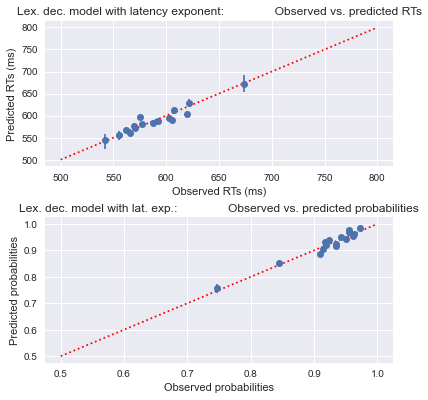

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)
fig.set_size_inches(5.5, 5.5)

# plot 1: RTs
ax1.errorbar(rt*1000, mu_rt.mean()*1000, yerr=yerr_rt, marker='o', linestyle='')
ax1.plot(np.linspace(500, 800, 10), np.linspace(500, 800, 10),\
         color='red', linestyle=':')
ax1.set_title('Lex. dec. model with latency exponent:\
               Observed vs. predicted RTs')
ax1.set_xlabel('Observed RTs (ms)')
ax1.set_ylabel('Predicted RTs (ms)')
ax1.grid(b=True, which='minor', color='w', linewidth=1.0)

# plot 2: probabilities
ax2.errorbar(accuracy, mu_prob.mean(), yerr=yerr_prob, marker='o',\
             linestyle='')
ax2.plot(np.linspace(50, 100, 10)/100,\
         np.linspace(50, 100, 10)/100,\
         color='red', linestyle=':')
ax2.set_title('Lex. dec. model with lat. exp.:\
               Observed vs. predicted probabilities')
ax2.set_xlabel('Observed probabilities')
ax2.set_ylabel('Predicted probabilities')
ax2.grid(b=True, which='minor', color='w', linewidth=1.0)

# clean up
plt.tight_layout(pad=0.5, w_pad=0.2, h_pad=0.7)

- the lexical decision model that explicitly models the latency exponent fits both latencies and probabilities very well
- the latencies, in particular, are modeled better than both the lexical decision model without a latency exponent, and the log-frequency model, which did not have a very good fit to the data at the extreme frequency bands (low or high frequencies)
- we list below the estimated posterior mean and $95\%$ credible interval (CRI) for the latency exponent
    - the posterior mean value and the CRI are pretty far away from the default value of $1$ we assumed in the previous model.

In [2]:
trace = az.from_netcdf("lex_dec_model_ACTR_2.nc")

In [12]:
latency_exponent_posterior = trace['posterior']['latency_exponent']
latency_exponent_posterior.mean()

<xarray.DataArray 'latency_exponent' ()>
array(0.28185137)

In [13]:
az.hdi(latency_exponent_posterior)

<xarray.Dataset>
Dimensions:           (hdi: 2)
Coordinates:
  * hdi               (hdi) <U6 'lower' 'higher'
Data variables:
    latency_exponent  (hdi) float64 0.04802 0.4528

The posterior estimates for the other parameters (means and $95\%$ CRIs) are provided below for reference:

In [15]:
trace['posterior'].mean()

<xarray.Dataset>
Dimensions:           ()
Data variables:
    threshold         float64 -0.4715
    decay             float64 0.1684
    intercept         float64 0.4861
    latency_factor    float64 0.3906
    latency_exponent  float64 0.2819
    noise             float64 1.779
    mu_rt             float64 0.5891
    mu_prob           float64 0.9232

In [16]:
az.hdi(trace['posterior'])

<xarray.Dataset>
Dimensions:           (hdi: 2, mu_prob_dim_0: 16, mu_rt_dim_0: 16)
Coordinates:
  * mu_rt_dim_0       (mu_rt_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * mu_prob_dim_0     (mu_prob_dim_0) int64 0 1 2 3 4 5 6 ... 10 11 12 13 14 15
  * hdi               (hdi) <U6 'lower' 'higher'
Data variables:
    threshold         (hdi) float64 -7.615 2.94
    decay             (hdi) float64 0.0001231 0.5326
    intercept         (hdi) float64 0.3717 0.5593
    latency_factor    (hdi) float64 0.01588 0.7735
    latency_exponent  (hdi) float64 0.04802 0.4528
    noise             (hdi) float64 1.614 1.964
    mu_rt             (mu_rt_dim_0, hdi) float64 0.5284 0.5603 ... 0.6552 0.6903
    mu_prob           (mu_prob_dim_0, hdi) float64 0.9826 0.9889 ... 0.7731